In [10]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_parquet("out/2019-07-27-conv2d.parquet")
print(len(df))

df["h_nelement"] = df["h.shape[0]"] * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"] * df["x.shape[1]"]
df["log10(fft_time/direct_time)"] = np.log10(df.fft_time / df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.head(50)

300


,fft_time,direct_time,mode,x.shape[0],x.shape[1],h.shape[0],h.shape[1],random_state,h_nelement,x_nelement,log10(fft_time/direct_time),fft_time/direct_time
0,0.000067,0.000011,full,3,3,3,3,0,9,9,0.798783,6.291918
1,0.000058,0.000010,full,3,3,4,4,1,16,9,0.744150,5.548175
2,0.000064,0.000013,full,3,3,6,6,2,36,9,0.690898,4.907926
3,0.000063,0.000019,full,3,3,9,9,3,81,9,0.522125,3.327553
4,0.000128,0.000034,full,3,3,14,14,4,196,9,0.581114,3.811661
5,0.000072,0.000062,full,3,3,21,21,5,441,9,0.068006,1.169515
6,0.000089,0.000120,full,3,3,31,31,6,961,9,-0.129241,0.742607
7,0.000103,0.000242,full,3,3,45,45,7,2025,9,-0.370945,0.425652
8,0.000157,0.000509,full,3,3,67,67,8,4489,9,-0.512423,0.307310
9,0.000279,0.001108,full,3,3,100,100,9,10000,9,-0.599024,0.251754


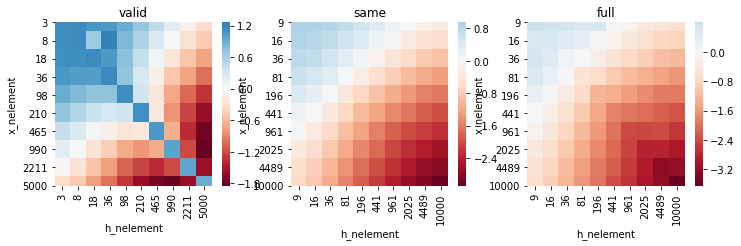

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log10(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

In [19]:
from scipy.optimize import curve_fit

def log_time(shapes, O, c):
    """
    Inputs
    ------
    sizes : array-like. x.shape[1] == 4
        Sizes. If convolving two arrays of size (m, n) and (a, b),
        sizes[0] == [m, n, a, b]
    
    >>> x = rand(m, n)
    >>> assert x.shape == (m, n)
    >>> h = rand(a, b)
    >>> assert h.shape == (a, b)
    >>> sizes = [[m, n, a, b], ...]
    """
    x_shape = shapes[:, [0, 1]]
    h_shape = shapes[:, [2, 3]]
    out_shape = {'full': [n + k - 1 for n, k in zip(x_shape, h_shape)],
                 'same': [n if n[0] > k[0] else k
                              for n, k in zip(x_shape, h_shape)],
                 'valid': [n-k+1 if n[0] > k[0] else k-n+1
                              for n, k in zip(x_shape, h_shape)]}
    full_out_shape = np.array(out_shape['full'])
    out_shape = np.array(out_shape[mode])
    
    kernel_size = np.vstack((np.product(x_shape, axis=1), np.product(h_shape, axis=1)))
    direct_time = np.min(kernel_size, axis=0) * np.product(out_shape, axis=1)
    fft_time = np.product(full_out_shape, axis=1) * np.sum(np.log(full_out_shape), axis=1)
    return np.log10((O * fft_time + c)/ direct_time)

def get_constant(df, mode="full"):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log10(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "x.shape[1]", "h.shape[0]", "h.shape[1]"]].values
    times = df["log10(fft_time/direct_time)"].values

    popt, pcov = curve_fit(log_time, shapes, times, p0 = (0.30, 5000.))
    return popt, pcov

In [20]:
bigOs = {}
for mode in ["same", "valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    O, std = get_constant(df[idx])
    bigOs[mode] = {"constant": O, "std": std}

/home/peter/miniconda3/envs/scipy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10


In [21]:
constants = pd.DataFrame(bigOs).T

In [22]:
constants

,constant,std
same,"[0.30114817667021476, 4870.414766623917]","[[0.0005959609060090236, -3.8788157104720233],..."
valid,"[0.4778544543585194, 986.8224887196674]","[[0.0032323557741853947, -3.4803993070573704],..."
full,"[0.24147639303574722, 4650.130649592644]","[[0.00019952532885720258, -1.4678799913805962]..."


In [18]:
constants["std"] / constants["constant"]

same     [[0.0019790928562584153, -0.000796391777067646...
valid    [[0.0067652902350974105, -0.003526756676343060...
full     [[0.0008263101543094645, -0.000315660826173587...
dtype: object